In [2]:
%run __init__.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from astropy.io import fits
from itertools import combinations
from tools import *
from before_stack import *
from conversion import *
from aper_phot import *
from cr_to_flux import *
from profile_q import *
from paper import obs_log

(-26.748330726001704, 0.013)
(-26.10415627504554, 0.016)


In [3]:
def para(mon):
    global img_name_uw1, img_name_v, spec_name_sun, spec_name_OH, img_name, err2_name
    global bg_reg_name, mask_name, mask_img, obs_log_name, wvm_name, phase_name
    global src_r, red, z, r_list
    global bg_r, bg_center, src_center
    img_name_uw1 = mon+'_stack_uw1.fits'
    img_name_v = mon+'_stack_uvv.fits'
    spec_name_sun = 'sun_1A.txt'
    spec_name_OH = '2019-07-15_emission_models_OH.txt'
    src_center = (1000, 1000)
    bg_reg_name = mon+'_sub_bg.reg'
    mask_name = mon+'_mask.reg'
    obs_log_name = mon+'_obs-log_Borisov_part.txt'
    wvm_name = mon+'_wvm.txt'
    phase_name = 'phase_correction.txt'
    if mon == 'sep':
        src_r = 45
        red = 0
        z = 2.859E+16
    elif mon == 'nov':
        src_r = 57
        red = 19
        z = 5.025E+16
    elif mon == 'dec':
        src_r = 67
        red = 14
        z = 6.278E+16
    elif mon == 'latedec':
        src_r = 71
        red = 13
        z = 6.146E+16
    else:
        pass
    img_name = mon+'_sub_red'+str(int(red))+'.fits'
    err2_name = mon+'_sub_red'+str(int(red))+'_err.fits'
    mask_img = mask_region(img_name, mask_name)
    bg = load_reg_list(bg_reg_name)
    bg_x = bg[1]
    bg_y = bg[0]
    bg_r = bg[2]
    bg_center = list(zip(bg_x, bg_y))

In [9]:
'''
mon = 'sep'
norm_list = []
r_list = np.linspace(0,3,4)
print(r_list)
for r in r_list:
    print(r)
    para(mon)
    img_name = mon+'_sub_red'+str(int(r))+'.fits'
    err2_name = mon+'_sub_red'+str(int(r))+'_err.fits'
    img_path = get_path('../docs/'+img_name)
    err2_path = get_path('../docs/'+err2_name)
    if os.path.exists(img_path):
        os.remove(img_path)
    if os.path.exists(err2_path):
        os.remove(err2_path)
    fits_sub(img_name_uw1, img_name_v, mon, r)
    mask_img = mask_region(img_name, mask_name)
    result = aper_phot(img_name, False,
                       src_center, src_r,
                       bg_center, bg_r,
                       'azim_median', 'multi_mean',
                       int(src_r/2.), mask_img, 0.)
    cr = result[0][0]
    flux = 1.2750906353215913e-12*cr
    num, num_err = flux2num(flux, 0.,
                            'fluorescenceOH.txt',
                            obs_log_name,
                            method='both_ends',
                            horizon_id=90004424,
                            if_show=False)
    q, q_err = num2q(num, 0.,
                     wvm_name, src_r,
                     if_show=False)
    aper_list, sur_bri_list, err_list = \
        sur_bri_profile(img_name, 90004424,
                        err2_name, obs_log_name,
                        src_center, src_r,
                        bg_center, bg_r,
                        6, int((src_r-6)/2), mask_img)
    colden_meas, colden_err = \
        colden_profile(sur_bri_list, 
                       err_list, 
                       obs_log_name, 
                       90004424)
    colden_model = sur_bri_model(wvm_name, 
                                 aper_list, 
                                 q)
    norm_r = norm(colden_meas, colden_model)
    norm_list.append(norm_r)
    os.remove(img_path)
    os.remove(err2_path)
print(norm_list)
''''''
mon = 'nov'
para(mon)
fits_sub(img_name_uw1, img_name_v, mon, 0)
'''

In [16]:
def oh(mon):
    para(mon)
    img_path = get_path('../docs/'+img_name)
    err2_path = get_path('../docs/'+err2_name)
    if os.path.exists(img_path):
        os.remove(img_path)
    if os.path.exists(err2_path):
        os.remove(err2_path)
    fits_sub(img_name_uw1, img_name_v, mon, red)
    mask_img = mask_region(img_name, mask_name)
    result = aper_phot(img_name, False,
                       src_center, src_r,
                       bg_center, bg_r,
                       'azim_median', 'multi_mean',
                       int(src_r/2.), mask_img, 0.)
    cr = result[0][0]
    bg_bri = result[3][0]
    # err
    src_err, pixel = circle_ct(err2_name, src_center, src_r, 'mean', mask_img)
    pixel_unmask = circle_ct(err2_name, src_center, src_r, 'median', mask_img)[1]
    src_err = (np.sqrt(src_err)*1.253/pixel)*pixel_unmask
    bg_bri_err, pixel = multi_circle_ct(err2_name, bg_center, bg_r, 'mean', mask_img)
    bg_bri_err = np.array(bg_bri_err)
    pixel = np.array(pixel)
    bg_bri_err = np.sqrt(np.sum(bg_bri_err/np.power(pixel,2)))/len(pixel)
    bg_err = bg_bri_err*pixel_unmask
    cr_err = np.sqrt(np.power(src_err,2)+np.power(bg_err,2))
    flux = 1.2750906353215913e-12*cr
    flux_err = 1.2750906353215913e-12*cr_err
    mean_delta = obs_log(mon+'_obs-log_Borisov_part.txt', 90004424)['delta']
    lumi = flux*4*np.pi*np.power(au2km(mean_delta)*1000*100, 2)
    num, num_err = flux2num(flux, flux_err,
                            'fluorescenceOH.txt',
                            obs_log_name,
                            method='both_ends',
                            horizon_id=90004424,
                            if_show=False)
    g_factor = lumi/num
    q, q_err = num2q(num, num_err,
                     wvm_name, src_r,
                     if_show=False)
    active_area = q/z
    active_area_err = q_err/z
    r = np.sqrt(active_area/(4*np.pi))
    r_err = active_area_err/(4*np.sqrt(np.pi*active_area))
    src_r_km = au2km(as2au(src_r,obs_log(obs_log_name, 90004424)['delta']))
    return (src_r, src_r_km), (cr, cr_err), (bg_bri, bg_bri_err), g_factor, (num, num_err), (q, q_err), (active_area/1e10, active_area_err/1e10), (r/1e5, r_err/1e5)

for mon in ['sep', 'nov', 'dec', 'latedec']:
    print('MONTH: '+mon)
    result = oh(mon)
    src_r, src_r_km = result[0]
    cr, cr_err = result[1]
    bg_bri, bg_bri_err = result[2]
    g_factor = result[3]
    num, num_err = result[4]
    q, q_err = result[5]
    active_area, active_area_err = result[6]
    r, r_err = result[7]
    print('APERTURE (arcsec/pixel): '+str(src_r)+' (km): '+str(src_r_km))
    print('COUNT RATE (cts/s): '+str(cr)+' +/- '+str(cr_err))
    print('BACKGROUND SB (cts/s/arcsec2): '+str(bg_bri)+' +/- '+str(bg_bri_err))
    print('g-factor (erg s-1 mol-1): '+str(g_factor))
    print('NUMBER (mol): '+str(num)+' +/- '+str(num_err))
    print('Water production rate (mol/s): '+str(q)+' +/- '+str(q_err))
    print('Active area(km2): '+str(active_area)+' +/- '+str(active_area_err))
    print('Radiu(km): '+str(r)+' +/- '+str(r_err)+'\n')


MONTH: sep
APERTURE (arcsec/pixel): 45 (km): 101117.44539295882
COUNT RATE (cts/s): 0.37055588283292723 +/- 0.14613129020911558
BACKGROUND SB (cts/s/arcsec2): -4.685091523288886e-05 +/- 1.7088096794437804e-05
g-factor (erg s-1 mol-1): 3.7125566794200407e-16
NUMBER (mol): 3.4356503357531443e+31 +/- 1.3548726103947742e+31
Water production rate (mol/s): 8.208479268393697e+26 +/- 3.2370709027063935e+26
Active area(km2): 2.87110152794463 +/- 1.1322388606877907
Radiu(km): 0.4779905858335922 +/- 0.09424945635955115

MONTH: nov
APERTURE (arcsec/pixel): 57 (km): 99863.98244532531
COUNT RATE (cts/s): 0.37055588283292723 +/- 0.17226184165378072
BACKGROUND SB (cts/s/arcsec2): 0.001636499243075433 +/- 1.1431962105290044e-05
g-factor (erg s-1 mol-1): 5.492454910821672e-16
NUMBER (mol): 1.411745621779703e+31 +/- 6.562840101072707e+30
Water production rate (mol/s): 3.1891098510589605e+26 +/- 1.4825346503197254e+26
Active area(km2): 0.6346487265788976 +/- 0.2950317712079055
Radiu(km): 0.224730373961785

/Users/zexixing/Research/swiftUVOT/note/../main/aper_phot.py:140: RuntimeWarning: invalid value encountered in sqrt
  count_err = (np.sqrt(np.sum(np.array(count_list)))/len(count_list))*1.2533*pixel_unmask


In [20]:
def aperture_phot(mon):
    para(mon)
    result_uw1 = aper_phot(img_name_uw1, 'uw1', 
                           src_center, src_r,
                           bg_center, bg_r,
                           'azim_median', 'multi_mean',
                           int(src_r/2.), mask_img, 0.)

    cr_uw1, cr_uw1_err = result_uw1[0]
    snr_uw1 = result_uw1[1]
    mag_uw1, mag_uw1_err = result_uw1[2]
    bg_cr_uw1, bg_cr_uw1_err = result_uw1[3]

    result_v = aper_phot(img_name_v, 'v', 
                         src_center, src_r,
                         bg_center, bg_r,
                         'azim_median', 'multi_mean',
                         #'total_mean', 'multi_mean',
                         int(src_r/2.), mask_img, 0.)

    cr_v, cr_v_err = result_v[0]
    snr_v = result_v[1]
    mag_v, mag_v_err = result_v[2]
    bg_cr_v, bg_cr_v_err = result_v[3]
    
    flux_uw1, flux_uw1_err = flux_ref_uw1(spec_name_sun,
                                          spec_name_OH,
                                          cr_uw1, cr_uw1_err,
                                          cr_v, cr_v_err, red)
    flux_v, flux_v_err = flux_ref_v(spec_name_sun, 
                                    spec_name_OH, 
                                    cr_uw1, cr_uw1_err, 
                                    cr_v, cr_v_err, red)
    
    return (cr_uw1, cr_uw1_err), snr_uw1, (mag_uw1, mag_uw1_err), (bg_cr_uw1, bg_cr_uw1_err), (flux_uw1, flux_uw1_err), (cr_v, cr_v_err), snr_v, (mag_v, mag_v_err), (bg_cr_v, bg_cr_v_err), (flux_v, flux_v_err)

for mon in ['sep', 'nov', 'dec', 'latedec']:
    print('MONTH: '+mon)
    result = aperture_phot(mon)
    cr_uw1, cr_uw1_err = result[0]
    snr_uw1 = result[1]
    mag_uw1, mag_uw1_err = result[2]
    bg_cr_uw1, bg_cr_uw1_err = result[3]
    flux_uw1, flux_uw1_err = result[4]
    cr_v, cr_v_err = result[5]
    snr_v = result[6]
    mag_v, mag_v_err = result[7]
    bg_cr_v, bg_cr_v_err = result[8]
    flux_v, flux_v_err = result[9]
    print('UW1:\n'
          +'COUNT RATE (cts/s): '+str(cr_uw1)+' +/- '+str(cr_uw1_err)+'\n'
          +'SNR: '+str(snr_uw1)+'\n'
          +'MAGNITUDE (mag): '+str(mag_uw1)+' +/- '+str(mag_uw1_err)+'\n'
          +'BACKGROUND CR (cts/s/arcsec2): '+str(bg_cr_uw1)+' +/- '+str(bg_cr_uw1_err)+'\n'
          +'FLUX from reflection (erg/s/cm2): '+str(flux_uw1)+' +/- '+str(flux_uw1_err))
    print('V:\n'
          +'COUNT RATE (cts/s): '+str(cr_v)+' +/- '+str(cr_v_err)+'\n'
          +'SNR: '+str(snr_v)+'\n'
          +'MAGNITUDE (mag): '+str(mag_v)+' +/- '+str(mag_v_err)+'\n'
          +'BACKGROUND CR (cts/s/arcsec2): '+str(bg_cr_v)+' +/- '+str(bg_cr_v_err)+'\n'
          +'FLUX (erg/s/cm2): '+str(flux_v)+' +/- '+str(flux_v_err)
          +'\n')


MONTH: sep
UW1:
COUNT RATE (cts/s): -0.01714060207286714 +/- 0.1292321616352648
SNR: 0.13263418220337053
MAGNITUDE (mag): nan +/- 8.186000606319654
BACKGROUND CR (cts/s/arcsec2): 0.004685459645979882 +/- 1.5083778678349639e-05
FLUX from reflection (erg/s/cm2): 9.119563012372182e-13 +/- 6.60685759546019e-13
V:
COUNT RATE (cts/s): 1.0242250118155507 +/- 0.7420211680749893
SNR: 1.3803177805192233
MAGNITUDE (mag): 17.86401155699697 +/- 0.7866916536775146
BACKGROUND CR (cts/s/arcsec2): 0.051015662628809105 +/- 8.65668888615776e-05
FLUX (erg/s/cm2): 2.4736750764909594e-13 +/- 1.7921054929542795e-13

MONTH: nov
UW1:
COUNT RATE (cts/s): 1.3083933688603728 +/- 0.16563538299484087
SNR: 7.899238346320762
MAGNITUDE (mag): 17.19815416403243 +/- 0.14068408440449945
BACKGROUND CR (cts/s/arcsec2): 0.0037283589615252355 +/- 1.0973426541684881e-05
FLUX from reflection (erg/s/cm2): 3.978156679361554e-12 +/- 4.62610991502475e-13
V:
COUNT RATE (cts/s): 7.7264779932438445 +/- 0.8984949395834829
SNR: 8.59935

In [31]:
def two_afr(mon, aper):
    para(mon)
    result_v = aper_phot(img_name_v, 'v', 
                         src_center, aper,
                         bg_center, bg_r,
                         'total_mean', 'multi_mean',
                         int(aper/2), mask_img, 0.)
    mag_v, mag_v_err = result_v[2]
    #mag_v = mag_v-0.64
    afr, afr_err = mag2afr(90004424, 
                           mag_v, mag_v_err, 
                           aper, obs_log_name, 
                           phase_name, False)
    afr_corr, afr_corr_err = mag2afr(90004424, 
                                     mag_v, mag_v_err, 
                                     aper, obs_log_name, 
                                     phase_name, True)
    return (afr, afr_err), (afr_corr, afr_corr_err)

for mon in ['sep', 'nov', 'dec', 'latedec']:
    print('MONTH: '+mon)
    if mon == 'sep':
        aper = 5.3
    elif mon == 'nov':
        aper = 5.7
    elif mon == 'dec':
        aper = 6.7
    elif mon == 'latedec':
        aper = 7.1
    result = two_afr(mon, aper)
    afr, afr_err = result[0]
    afr_corr, afr_corr_err = result[1]
    print('AFR (m): '+str(afr)+' +/- '+str(afr_err)+'\n'
          'AFR corrected by phase (m): '+str(afr_corr)+' +/- '+str(afr_corr_err)+'\n')


MONTH: sep
AFR (m): 0.5445257168561213 +/- 0.030526908971504053
AFR corrected by phase (m): 0.9900611588098033 +/- 0.05550427819223563

MONTH: nov
AFR (m): 0.48917748425149093 +/- 0.01904408068702419
AFR corrected by phase (m): 1.055670138075344 +/- 0.04109810433967769

MONTH: dec
AFR (m): 0.43448440137789884 +/- 0.02474354488136542
AFR corrected by phase (m): 1.0139241434714705 +/- 0.057742182390722055

MONTH: latedec
AFR (m): 0.3836744515590049 +/- 0.01043876840236908
AFR corrected by phase (m): 0.9033240714884285 +/- 0.024577061975946106



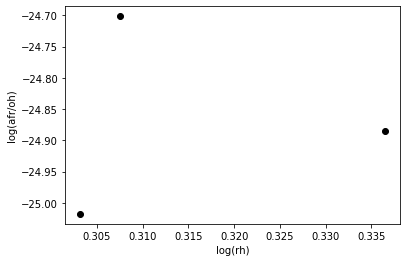

In [9]:
afr_oh = [-24.88515156928604, -25.017864448393105, -24.701564711538566]
rh = [2.17, 2.01, 2.03]
plt.plot(np.log10(np.array(rh)), afr_oh, 'ko')
plt.xlabel('log(rh)')
plt.ylabel('log(afr/oh)')
plt.show()

In [5]:
def colden_profile_plot_red(red):
    spec_name_sun = 'sun_1A.txt'
    spec_name_OH = '2019-07-15_emission_models_OH.txt'
    src_center = (1000, 1000)
    phase_name = 'phase_correction.txt'
    horizon_id = 90004424
    src_r = 71
    delta = 1.94313501038852
    if red == 0:
        q = 3.8288635482163465e+26
        color = 'DarkOrange'
        show = 0
    elif red == 7:
        q = 4.427736349389011e+26
        color = 'Orange'
        show = 3e11
    elif red == 14:
        q = 4.974731415321788e+26
        color = 'y'
        show = 6e11
    elif red == 21:
        q = 5.3331683249772645e+26
        color = 'olive'
        show = 9e11
    else:
        pass
    img_name = 'latedec_sub_red'+str(int(red))+'.fits'
    err2_name = 'latedec_sub_red'+str(int(red))+'_err.fits'
    bg_reg_name = 'latedec_sub_bg.reg'
    mask_name = 'latedec_mask.reg'
    obs_log_name = 'latedec_obs-log_Borisov_part.txt'
    wvm_name = 'latedec_wvm.txt'
    bg = load_reg_list(bg_reg_name)
    bg_x = bg[1]
    bg_y = bg[0]
    bg_r = bg[2]
    bg_center = list(zip(bg_x, bg_y))
    mask_img = mask_region(img_name, mask_name)
    aper_list, sur_bri_list, err_list = \
        sur_bri_profile(img_name, horizon_id,
                        err2_name,obs_log_name,
                        src_center, src_r,
                        bg_center, bg_r,
                        6, int((src_r-6)/2), mask_img)
    colden_meas, colden_err = \
        colden_profile(sur_bri_list, 
                       err_list, 
                       obs_log_name, 
                       horizon_id)
    colden_meas = np.array(colden_meas)+show
    colden_model = sur_bri_model(wvm_name, 
                                 aper_list, 
                                 q)
    colden_model = np.array(colden_model)+show
    return aper_list, colden_meas, colden_model, colden_err, color

def colden_profile_plot(mon):
    spec_name_sun = 'sun_1A.txt'
    spec_name_OH = '2019-07-15_emission_models_OH.txt'
    src_center = (1000, 1000)
    phase_name = 'phase_correction.txt'
    horizon_id = 90004424
    if mon =='sep':
        src_r = 45
        red = 0
        q = -2.655764475272607e+26
        color = 'b'
        show = -2e11
        delta = 3.09822744350658
    elif mon =='nov':
        src_r = 57
        red = 19
        q = 6.994133610979295e+26 
        color = 'g'
        show = 0
        delta = 2.41564853382735
    elif mon == 'dec':
        src_r = 67
        red = 14
        q = 1.070103231339096e+27
        color = 'r'
        show = 2e11
        delta = 2.04435148882201
    elif mon == 'latedec':
        src_r = 71
        red = 13
        q = 4.873732439900419e+26
        color = 'y'
        show = 6e11
        delta = 1.94313501038852
    else:
        pass
    img_name = mon+'_sub_red'+str(int(red))+'.fits'
    err2_name = mon+'_sub_red'+str(int(red))+'_err.fits'
    bg_reg_name = mon+'_sub_bg.reg'
    mask_name = mon+'_mask.reg'
    obs_log_name = mon+'_obs-log_Borisov_part.txt'
    wvm_name = mon+'_wvm.txt'
    bg = load_reg_list(bg_reg_name)
    bg_x = bg[1]
    bg_y = bg[0]
    bg_r = bg[2]
    bg_center = list(zip(bg_x, bg_y))
    mask_img = mask_region(img_name, mask_name)
    aper_list, sur_bri_list, err_list = \
        sur_bri_profile(img_name, horizon_id,
                        err2_name,obs_log_name,
                        src_center, src_r,
                        bg_center, bg_r,
                        6, int((src_r-6)/2), mask_img)
    colden_meas, colden_err = \
        colden_profile(sur_bri_list, 
                       err_list, 
                       obs_log_name, 
                       horizon_id)
    colden_meas = np.array(colden_meas)+show
    colden_model = sur_bri_model(wvm_name, 
                                 aper_list, 
                                 q)
    colden_model = np.array(colden_model)+show
    return aper_list, colden_meas, colden_model, colden_err, color

/Users/zexixing/Research/swiftUVOT/note/../main/aper_phot.py:140: RuntimeWarning: invalid value encountered in sqrt
  count_err = (np.sqrt(np.sum(np.array(count_list)))/len(count_list))*1.2533*pixel_unmask


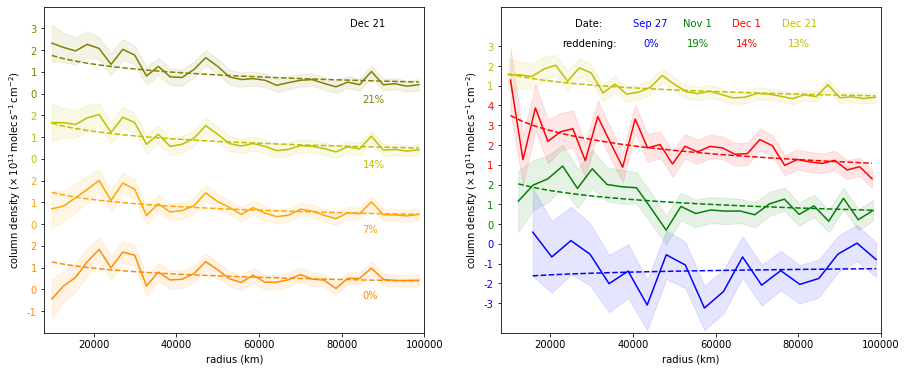

In [6]:
#fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
#ax1 = fig.add_axes([0.1, 0.9, 0.8, 0.9],
#                   xticklabels=[])
#ax2 = fig.add_axes([0.1, 0.0, 0.8, 0.9])

#ax1
ticks_ax1 = [-1e11, 0, 1e11, 2e11, 3e11, 4e11, 5e11, 6e11, 7e11, 8e11, 9e11,10e11,11e11,12e11]
ticks_text_ax1 = [-1, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2,3]
ticks_c_ax1 = ['DarkOrange', 'DarkOrange', 'DarkOrange', 'DarkOrange', 'Orange', 'Orange', 'Orange', 'y', 'y', 'y', 'olive', 'olive', 'olive','olive']
for red in [0,7,14,21]:
    aper_list, colden_meas, colden_model, colden_err, color = colden_profile_plot_red(red)
    ax1.plot(aper_list, colden_meas, color, linestyle='-')
    ax1.plot(aper_list, colden_model, color, linestyle='--')
    ax1.fill_between(aper_list, np.array(colden_meas)-np.array(colden_err), np.array(colden_meas)+np.array(colden_err), color=color, alpha=0.1)
ax1.set_ylim(-2e11,13e11)
ax1.set_yticks(ticks_ax1)
ax1.set_yticklabels(ticks_text_ax1)
i = 0
for tick in ax1.get_yticklabels():
    tick.set_color(ticks_c_ax1[i])
    i += 1
ax1.set_ylabel('column density ('+r'$\times\,10^{11}\,\mathrm{molec}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}$)')
ax1.set_xlim(8000,100000)
ax1.text(85000,-0.4e11, '0%', color='DarkOrange')
ax1.text(85000,2.6e11, '7%', color='Orange')
ax1.text(85000,5.6e11, '14%', color='y')
ax1.text(85000,8.6e11, '21%', color='olive')
ax1.text(82000,12.1e11, 'Dec 21', color='k')
ax1.set_xlim(8000,100000)
ax1.set_xlabel('radius (km)')

#ax2
ticks = [-4e11,-3e11, -2e11, -1e11, 0, 1e11, 2e11, 3e11, 4e11, 5e11, 6e11, 7e11, 8e11, 9e11]
ticks_text = [-3,-2, -1, 0, 0, 1, 2, 1, 2, 3, 4, 1, 2, 3]
ticks_c = ['b','b', 'b', 'b', 'g', 'g', 'g', 'r', 'r', 'r', 'r', 'y', 'y', 'y']
for mon in ['sep', 'nov', 'dec', 'latedec']:
    aper_list, colden_meas, colden_model, colden_err, color = colden_profile_plot(mon)
    ax2.plot(aper_list, colden_meas, color, linestyle='-')
    ax2.plot(aper_list, colden_model, color, linestyle='--')
    ax2.fill_between(aper_list, np.array(colden_meas)-np.array(colden_err), np.array(colden_meas)+np.array(colden_err), color=color, alpha=0.1)
ax2.set_ylim(-5.5e11,11e11)
ax2.set_yticks(ticks)
ax2.set_yticklabels(ticks_text)
i = 0
for tick in plt.gca().get_yticklabels():
    tick.set_color(ticks_c[i])
    i += 1
ax2.set_ylabel('column density ('+r'$\times\,10^{11}\,\mathrm{molec}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}$)')
ax2.set_xlim(8000,100000)
ax2.set_xlabel('radius (km)')
ax2.text(26000,10e11, 'Date:', color='k')
ax2.text(40000,10e11, 'Sep 27', color='b')
ax2.text(52000,10e11, 'Nov 1', color='g')
ax2.text(64000,10e11, 'Dec 1', color='r')
ax2.text(76000,10e11, 'Dec 21', color='y')
ax2.text(23000,9e11, 'reddening:', color='k')
ax2.text(42500,9e11, '0%', color='b')
ax2.text(53000,9e11, '19%', color='g')
ax2.text(65000,9e11, '14%', color='r')
ax2.text(77500,9e11, '13%', color='y')

save_path = get_path('../draft/profile_2.png')
plt.savefig(save_path, bbox_inches='tight', dpi=400)
plt.show()

In [ ]:
def perc_aper(mon, aperture, r):
    para(mon)
    src_center = (1000, 1000)
    mask_name = mon+'_mask.reg'
    mask_img = mask_region(img_name_uw1, mask_name)
    result_uw1 = aper_phot(img_name_uw1, 'uw1', 
                           src_center, aperture,
                           bg_center, bg_r,
                           'azim_mean','multi_mean',
                           5, mask_img, False)
    result_v = aper_phot(img_name_v, 'v', 
                           src_center, aperture,
                           bg_center, bg_r,
                           'azim_mean','multi_mean',
                           5, mask_img, False)
    cr_uw1, cr_uw1_err = result_uw1[0]
    cr_v, cr_v_err = result_v[0]
    beta = 0.09276191501510327
    beta = reddening_correct(r)*beta
    return ((cr_uw1 - beta*cr_v)/abs(cr_uw1))*100

def mon2aper_list(mon):
    if mon == 'sep':
        aper1 = np.arange(6, 15, 1)
        aper2 = np.arange(15, 155, 5)
        return np.concatenate((aper1, aper2))
    elif mon == 'nov':
        aper1 = np.arange(6, 50, 1)
        aper2 = np.arange(50, 155, 5)
        return np.concatenate((aper1, aper2))
    elif mon == 'dec':
        aper1 = np.arange(6, 40, 1)
        aper2 = np.arange(40, 205, 5)
        return np.concatenate((aper1, aper2))
    
def perc_aper_l(mon, r):
    aperture_list = mon2aper_list(mon)
    perc_aper_list = []
    for aperture in aperture_list:
        perc_aper_i = perc_aper(mon, aperture, r)
        perc_aper_list.append(perc_aper_i)
    return aperture_list, perc_aper_list

aper_sep, perc_sep = perc_aper_l('sep', 0)
#aper_nov, perc_nov = perc_aper_l('nov', 0)
#aper_dec, perc_dec = perc_aper_l('dec', 0)
aper_nov, perc_nov_r = perc_aper_l('nov', 9)
aper_dec, perc_dec_r = perc_aper_l('dec', 9)

#plt.plot(aper_nov, perc_nov, 'g--', label='Nov r=0%')
#plt.plot(aper_dec, perc_dec, 'r--', label='Dec r=0%')
plt.plot(au2km(as2au(np.array(aper_sep),3.1)), perc_sep, 'b', label='Sep r=0%')
plt.plot(au2km(as2au(np.array(aper_nov),2.42)), perc_nov_r, 'g', label='Nov r=9%')
plt.plot(au2km(as2au(np.array(aper_dec),2.04)), perc_dec_r, 'r', label='Dec r=9%')
plt.xlabel('aperture (km)')
plt.ylabel(r'(uw1-$\beta \cdot$v)/uw1 (%)')
plt.legend()
plt.ylim(-25,100)
plt.show()

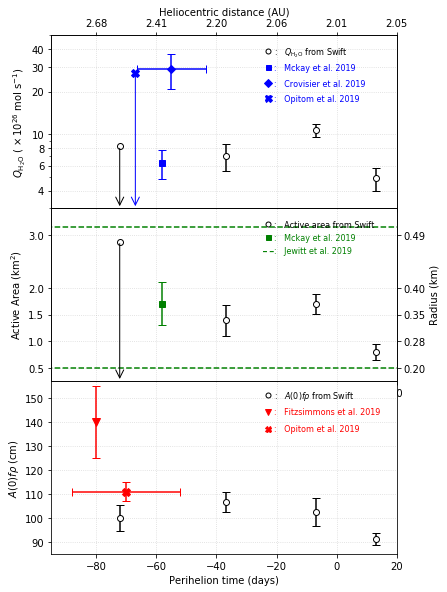

In [33]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 1.2, 0.8, 0.6],
                   xticklabels=[])
ax2 = fig.add_axes([0.1, 0.6, 0.8, 0.6])
ax3 = fig.add_axes([0.1, 0, 0.8, 0.6])
ax0 = ax1.twiny()
#ax4 = ax2.twinx()
ax1.set_ylim([3e26,5e27])
ax2.set_ylim(0.25,3.5)
#ax4.set_ylim(0.25,3.5)

time = [-72.2, -36.7, -7.0, 13.0]
afr = [99.92220819212154 , 106.54381335975072 , 102.33058680614149 , 91.16824262122405 ]
afr_err = [5.6017852955116694, 4.1478380417100204 , 5.827646422620271, 2.4804470730509225]
q = [8.21e26, 6.994133610979295e26 , 10.70103231339096e26 , 4.873732439900419e+26]
q_err = [8.21e26, 1.4825346503197254e26
,1.1758504034247893e26, 0.9042020697516337e26]
area = [2.87110152794463, 1.3918673852695114, 1.7045288807567636, 0.7929925870322843]
area_err = [2.87110152794463, 0.2950317712079055, 0.18729697410398044, 0.14712041486359156]
radius = [0.4779905858335922, 0.332808183864245, 0.36829621028143555, 0.25120578223979845]   

ax1.plot(time[1:4], q[1:4], 'ko', MarkerSize=6, label=r'$Q_\mathrm{H_2O}$'+' from Swift', mfc='w')
ax1.errorbar(time[1:4], q[1:4], yerr=q_err[1:4], color='k', fmt='none', alpha=1, MarkerSize=3, capsize=4)
ax1.annotate('', xy=(time[0],ax1.get_ylim()[0]), xytext=(time[0], q[0]), arrowprops={'arrowstyle':'->','color':'k'} ,va='center',size=20)
ax1.plot(time[0],q[0],'ko',MarkerSize=6, mfc='w')

ax1.plot(-58,6.3e26,'bs', MarkerSize=6, label='Mckay et al. 2019', mfc='b')
ax1.errorbar(-58,6.3e26, 1.5e26,c='b',fmt='none', alpha=1, capsize=4)
ax1.annotate('', xy=(-67,ax1.get_ylim()[0]), xytext=(-67, 27e26), arrowprops=dict(arrowstyle='->',color='b',fc='b'),va='center',size=20, label='Opitom et al. 2019')
ax1.plot(-67,27e26,'bX',MarkerSize=8)
ax1.plot(-55,29e26,'bD',MarkerSize=6,mfc='b', label='Crovisier et al. 2019')
ax1.errorbar(-55,29e26, 8e26,c='b',fmt='none', alpha=1, capsize=4)
ax1.errorbar(-55,29e26, xerr=11.5,c='b',fmt='none', alpha=1, capsize=4)

ax1.plot(-23,3.9e27,'ko', MarkerSize=5,mfc='none')
ax1.text(-21,3.65e27,':   '+r'$Q_\mathrm{H_2O}$'+' from Swift', fontsize=8, color='k')
ax1.plot(-23,3e27,'bs', MarkerSize=5,mfc='b')
ax1.text(-21,2.83e27,':   '+'Mckay et al. 2019', fontsize=8, color='b')
ax1.plot(-23,2.3e27,'bD', MarkerSize=5,mfc='b')
ax1.text(-21,2.2e27,':   '+'Crovisier et al. 2019', fontsize=8, color='b')
ax1.plot(-23,1.8e27,'bX', MarkerSize=7,mfc='b')
ax1.text(-21,1.72e27,':   '+'Opitom et al. 2019', fontsize=8, color='b')

ax2.plot(time[1:4], area[1:4], 'ko', MarkerSize=6, label=r'Active Area'+' from Swift', mfc='w')
ax2.errorbar(time[1:4], area[1:4], yerr=area_err[1:4], color='k', fmt='none', alpha=1, MarkerSize=3, capsize=4)
ax2.annotate('', xy=(time[0],ax2.get_ylim()[0]), xytext=(time[0], area[0]), arrowprops={'arrowstyle':'->','color':'k'} ,va='center',size=20)
ax2.plot(time[0],area[0],'ko',MarkerSize=6, mfc='w')

ax2.plot(-58,1.7,'gs', MarkerSize=6, label='Mckay et al. 2019', mfc='g')
ax2.errorbar(-58,1.7, 0.404749055585537,c='g',fmt='none', alpha=1, capsize=4)
#ax2.plot(-89,5,'g^', MarkerSize=6, label='Guzik et al. 2019', mfc='g')
#ax2.fill([-95, 20, 20, -95], [0.5026548245743669, 0.5026548245743669, 3.141592653589793, 3.141592653589793], fill=False, hatch='\\')

ax2.plot(-23,3.2,'ko', MarkerSize=5,mfc='none')
ax2.text(-21,3.15,':   '+'Active area'+' from Swift', fontsize=8, color='k')
ax2.plot(-23,2.95,'gs', MarkerSize=5,mfc='g')
ax2.text(-21,2.9,':   '+'Mckay et al. 2019', fontsize=8, color='g')
#ax2.plot(-23,4.1,'g^', MarkerSize=5,mfc='g')
#ax2.text(-21,4.0,':   '+'Guzik et al. 2019', fontsize=8, color='g')
ax2.text(-24.5,2.74,'_ _', fontsize=8, color='g',fontweight='bold')
ax2.text(-21,2.65,':   '+'Jewitt et al. 2019', fontsize=8, color='g')

ax3.plot(time[:4], afr[:4], 'wo', MarkerSize=6, label=r'$A(0)f\rho$'+' from Swift', mec='k')
ax3.errorbar(time[:4], afr[:4], afr_err[:4], fmt='none', color='k', alpha=1, MarkerSize=3, capsize=4)

ax3.plot(-80,140,'rv',MarkerSize=8, label='Fitzsimmons et al. 2019')
ax3.errorbar(-80,140, 15, c='r',fmt='none', alpha=1, capsize=4)
ax3.plot(-70,110.8,'rX',MarkerSize=8, mec='r', label='Opitom et al. 2019')
ax3.errorbar(-70,110.9, 3.9, c='r',fmt='none', alpha=1, capsize=4)
ax3.errorbar(-70,110.9, xerr=18, c='r',fmt='none', alpha=1, capsize=4)

ax3.plot(-23,151,'ko', MarkerSize=5, mfc='w')
ax3.text(-21,150,':   '+r'$A(0)f\rho$'+' from Swift', fontsize=8, color='k')
ax3.plot(-23,144,'rv', MarkerSize=6)
ax3.text(-21,143,':   '+'Fitzsimmons et al. 2019', fontsize=8, color='r')
ax3.plot(-23,137,'rX', MarkerSize=6)
ax3.text(-21,136,':   '+'Opitom et al. 2019', fontsize=8, color='r') 

ax1.set_ylabel(r'$Q_\mathrm{H_2O}$ '+r'( $\times\,10^{26}$ mol $\mathrm{s}^{-1}$)')
ax2.set_ylabel(r'Active Area'+' (km'+r'$^2$)')
ax3.set_ylabel(r'$A(0)f\rho$'+' (cm)')
ax3.set_xlabel('Perihelion time (days)')
time_plot = [-80, -60, -40, -20, 0, 20]
r_plot = ['2.68', '2.41', '2.20', '2.06', '2.01', '2.05']
area_plot = [0.5,1,1.5,2,3]
radius_plot = ['0.20','0.28','0.35','0.40', '0.49']
q_plot = [4e26,6e26,8e26,1e27,2e27,3e27,4e27]
q_label=['4','6','8','10','20','30','40']
afr_plot = [90,100,110,120,130,140,150]
ax1.set_xticks(time_plot)
ax2.set_xticks(time_plot)
ax3.set_xticks(time_plot)
ax0.set_xticks(time_plot)
ax0.xaxis.tick_top()
ax0.set_xticklabels(r_plot)
ax1.set_xlim(-95,20)
ax2.set_xlim(-95,20)
ax3.set_xlim(-95,20)
ax0.set_xlim(-95,20)
ax1.set_yscale('log')
#ax2.set_yscale('log')
ax4=ax2.twinx()
ax2.set_ylim(0.25,3.5)
ax4.set_ylim(0.25,3.5)
ax4.set_yticks(area_plot)
ax2.set_yticks(area_plot)
ax4.yaxis.tick_right()
ax4.set_yticklabels(radius_plot)
ax0.set_xlabel('Heliocentric distance (AU)')
ax4.set_ylabel('Radius (km)')
ax1.set_yticks(q_plot)
ax1.set_yticklabels(q_label)
ax3.set_yticks(afr_plot)
ax3.set_yticklabels(afr_plot)
ax1.set_ylim(3e26,5e27)
ax3.set_ylim(85,157)
ax1.grid(linestyle=':',alpha=0.5)
ax2.grid(linestyle=':',alpha=0.5)
ax3.grid(linestyle=':',alpha=0.5)
ax2.axhline(y=3.141592653589793,xmin=-95,xmax=20,linestyle='--',c='g')
ax2.axhline(y=0.5026548245743669,xmin=-95,xmax=20,linestyle='--',c='g')
save_path=get_path('../draft/comparison_3.png')
plt.savefig(save_path, bbox_inches='tight', dpi=400)
plt.show()

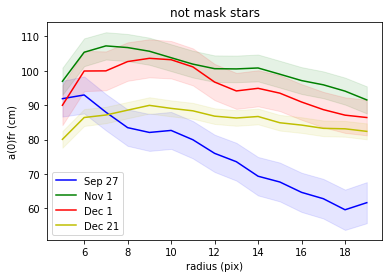

In [36]:
def afr_plot(mon, aperture, method, mask):
    para(mon)
    '''
    result_v = aper_phot(img_name_v, 'v', 
                         src_center, aperture,
                         bg_center, bg_r,
                         'azim_median', 'multi_mean',
                         int(aperture/3), mask_img, 0.)
    mag_v, mag_v_err = result_v[2]
    '''
    if mask == True:
        result_v = aper_phot(img_name_v, 'v', 
                             src_center, aperture,
                             bg_center, bg_r,
                             method, 'multi_mean',
                             int(aperture/2), mask_img, 0.)
    else:
        result_v = aper_phot(img_name_v, 'v', 
                             src_center, aperture,
                             bg_center, bg_r,
                             method, 'multi_mean',
                     int(aperture/2), False, 0.)
    mag_v, mag_v_err = result_v[2]
    afr_corr, afr_corr_err = mag2afr(90004424, 
                                     mag_v, mag_v_err, 
                                     aperture, obs_log_name, 
                                     phase_name, True)
    #return mag_v,mag_v_err
    return afr_corr, afr_corr_err


def mon2aper_list(mon):
    if mon == 'sep':
        aper1 = np.arange(5, 20, 1)
        aper2 = np.arange(15, 155, 5)
        return aper1
        #return np.concatenate((aper1, aper2))
    elif mon == 'nov':
        aper1 = np.arange(5, 20, 1)
        aper2 = np.arange(50, 155, 5)
        return aper1
        #return np.concatenate((aper1, aper2))
    elif mon == 'dec':
        aper1 = np.arange(5, 20, 1)
        aper2 = np.arange(40, 205, 20)
        return aper1
        #return np.concatenate((aper1, aper2))
    elif mon == 'latedec':
        return np.arange(5, 20, 1)
    
def afr_aper_l(mon, method, mask):
    aperture_list = mon2aper_list(mon)
    afr_list = []
    afr_err_list = []
    for aperture in aperture_list:
        afr_i, afr_err_i = afr_plot(mon, aperture, method, mask)
        afr_list.append(afr_i*100)
        afr_err_list.append(afr_err_i*100)
    return aperture_list, np.array(afr_list), np.array(afr_err_list)

aper_sep, afr_sep, afr_err_sep = afr_aper_l('sep', 'total_mean', False)
aper_nov, afr_nov, afr_err_nov = afr_aper_l('nov', 'total_mean', False)
aper_dec, afr_dec, afr_err_dec = afr_aper_l('dec', 'total_mean', False)
aper_latedec, afr_latedec, afr_err_latedec = afr_aper_l('latedec', 'total_mean', False)
'''
aper_sep, afr_sep, afr_err_sep = afr_aper_l('sep', 'azim_median', True)
aper_nov, afr_nov, afr_err_nov = afr_aper_l('nov', 'azim_median', True)
aper_dec, afr_dec, afr_err_dec = afr_aper_l('dec', 'azim_median', True)
aper_latedec, afr_latedec, afr_err_latedec = afr_aper_l('latedec', 'azim_median', True)

aper_sep = [au2km(as2au(i,3.09816061924855)) for i in aper_sep]
aper_nov = [au2km(as2au(i,2.41562442021788)) for i in aper_nov]
aper_dec = [au2km(as2au(i,2.04435148882201)) for i in aper_dec]
aper_latedec = [au2km(as2au(i,1.94313501038852)) for i in aper_latedec]
'''

plt.plot(aper_sep, afr_sep, 'b', label='Sep 27')
plt.plot(aper_nov, afr_nov, 'g', label='Nov 1')
plt.plot(aper_dec, afr_dec, 'r', label='Dec 1')
plt.plot(aper_latedec, afr_latedec, 'y', label='Dec 21')

plt.fill_between(aper_sep, afr_sep-afr_err_sep, afr_sep+afr_err_sep, color='b', alpha=0.1)
plt.fill_between(aper_nov, afr_nov-afr_err_nov, afr_nov+afr_err_nov, color='g', alpha=0.1)
plt.fill_between(aper_dec, afr_dec-afr_err_dec, afr_dec+afr_err_dec, color='r', alpha=0.1)
plt.fill_between(aper_latedec, afr_latedec-afr_err_latedec, afr_latedec+afr_err_latedec, color='y', alpha=0.1)

plt.legend()
plt.ylabel('a(0)fr (cm)')
plt.xlabel('radius (pix)')
#plt.xlim(5000,30000)
#plt.ylim(0,400)
plt.title('not mask stars')
#plt.yscale('log')
#plt.xscale('log')
plt.show()


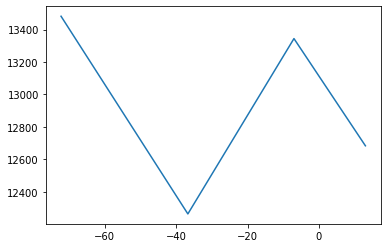

In [3]:
x = [-72.2,-36.7,-7,13]
y = [au2km(as2au(6,3.09816061924855)),au2km(as2au(7,2.41562442021788)),au2km(as2au(9,2.04435148882201)),au2km(as2au(9,1.94313501038852))]
plt.plot(x,y)
plt.show()